# K-means Clustering

### Learning Objectives 
- Define an objective function that gives rise to a "good" clustering (formulate K-means as an optimization problem)
- Recognize and explain challenges in selecting the number of clusters
- Recognize that different cluster mean initializations can affect k-means algorithm output

Run the cell below to import necessary packages and the filenames

In [ ]:
from typing import List, Set, Dict, Tuple

import pickle
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker, cm

from testing import TestHelper

%matplotlib inline

TOY_FILE = "./data/toy_data.csv"  # filepath of toy dataset
FULL_FILE = "./data/full_data.csv"  # filepath of full dataset

<a name="data"></a>

# Part I: Data Inspection






### Load data

Write a function to read in each datafile as a single 2D `X` data array. Note that there is no label or target column, `Y`, because this is an unsupervised machine learning scenario.

In [ ]:

def load_data(filename: str) -> np.ndarray:
    """Load in the datafiles

    Parameters
    ----------
    filename: type `str`
      filename 

    Returns X of type np.array, shape (N, M) 
    """

    X = []
    
    import csv
    with open(filename, 'r') as f: 
        reader = csv.reader(f)

        for row in reader: 
            k = []
            for i in row:
          
                k.append(float(i))
            X.append(k)
            
        X = np.array(X)
        

    return X
    

In [ ]:

toy_X = load_data(TOY_FILE) 
print(toy_X.shape)

full_X = load_data(FULL_FILE)# X.shape = (2318,2)
print(full_X.shape)

(100, 2)
(2318, 2)


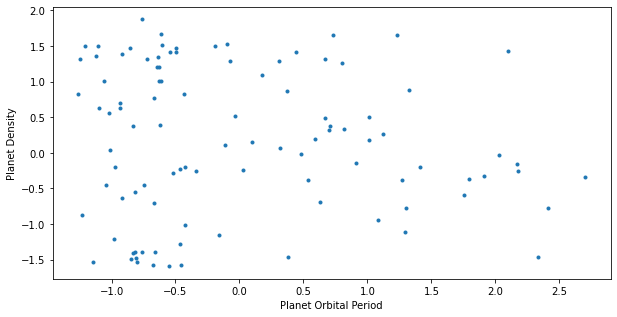

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(toy_X[:,0],toy_X[:,1],'.') 
plt.xlabel('Planet Orbital Period') 
plt.ylabel('Planet Density') 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")



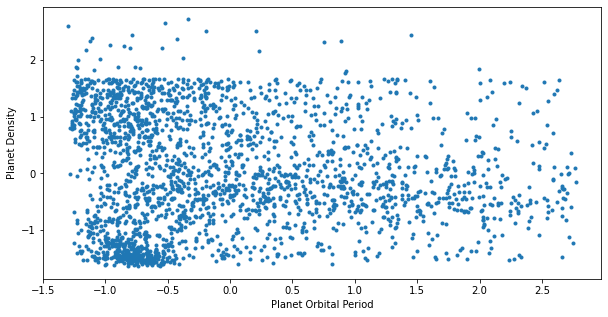

In [ ]:
plt.figure(figsize=(10,5)) 
plt.plot(full_X[:,0],full_X[:,1],'.') 
plt.xlabel('Planet Orbital Period') 
plt.ylabel('Planet Density') 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


###  K-means Objective Function 

Write a function that calculates the mean squared distance from each point to its assigned cluster.

In [ ]:
def kmeans_objective(X: np.ndarray, centers: np.ndarray, assignment: np.ndarray) -> float:
    """Compute the K-means loss.

    Parameters
    ----------
    X: numpy ndarray, shape (N, M)
        Input data, each row is a data point
    centers: numpy ndarray, shape (K, M)
        Cluster center array, where each row is a cluster center
    assignment: numpy ndarray, shape (N,) 
        Assignments array, where the i-th entry is an int from {0,...,K-1}
        representing the cluster index for the i-th point in X

    Returns mean squared distance from each point to the center for its assigned cluster
    """
    ans = 0
    loss = 0
    N = X.shape[0]
    for i in range(N):
        c = centers[assignment[i]]
        
        #ans += (X[i][0]-c[0])**2+(X[i][1]-c[1])**2
        ans += (X[i]- c)@(X[i]- c)/N
    
        

    return ans



In [ ]:
X = np.array([[0,1], 
              [1,0],
              [1,0]])

centers = np.array([[0,1], 
                    [1,0]])

assignment = np.array([0,1,1]) 

loss = kmeans_objective(X,centers,assignment) 
print('Your calculated loss (mean-squared distance) = % 0.2f' % loss )

Your calculated loss (mean-squared distance) =  0.00


 Update Cluster Assignment 

Write a function that re-assigns each datapoint to the nearest cluster center.



In [ ]:
def update_assignment(X: np.ndarray, centers: np.ndarray, assignment: np.ndarray) -> Tuple[np.ndarray, bool]: 
    """Assign datapoints to the nearest cluster center

    Parameters
    ----------
    X: numpy ndarray, shape (N, M)
        Input data, each row is a data point
    centers: numpy ndarray, shape (K, M)
        Cluster center array, where each row is a cluster center
    assignment: numpy ndarray, shape (N,) 
        Assignments array, where the i-th entry is an int from {0,...,K-1}
        representing the cluster index for the i-th point in X
        
    Returns
    -------
    A tuple of (assignment, assign_changed) where
        assignment: a numpy ndarray, shape (N,)
            Updated assignments for each datapoint
        assign_changed: bool
            flag for whether any of the datapoints changed assignment
    """
    
    
    N  = X.shape[0]
    K = centers.shape[0]
    ass = False
    new_ass = np.zeros(N, dtype = int) -1
    for i in range(N):
        best = -1
        best_dia =float('inf')
        for assign in range(K):
            d = X[i] - centers[assign]
            dis = d@d
            if dis< best_dia:
                best_dia = dis
                best = assign
        new_ass[i] = best
        if assignment[i] != best:
            ass = True
    return new_ass , ass
            
    
    

In [ ]:

X = np.array([[0,1], #3 datapoints, 2 features
              [1,0],
              [1,0]])

centers = np.array([[0,1], 
                    [1,0]])

assignment = np.array([1,0,0]) 


new_assignment,if_changed = update_assignment(X,centers,assignment) 
print('(True or False) Your assignments have changed. %s.' % if_changed)  #Correct output is True
print('Your new assignments are %s.' % new_assignment) #Correct output is [0 1 1]

(True or False) Your assignments have changed. True.
Your new assignments are [0 1 1].


 Update Cluster Centers 
Write a function that updates the cluster center to reflect the midpoint of data assigned to that cluster. 



In [ ]:
def update_centers(X: np.ndarray, assignment: np.ndarray, K: int) -> np.ndarray:
    """Update cluster centers to reflect midpoint of data currently assigned to that cluster

    Parameters
    ----------
    X: numpy ndarray, shape (N, M)
        Input data, each row is a data point
    assignment: numpy ndarray, shape (N,) 
        Assignments array, where the i-th entry is an int from {0,...,K-1}
        representing the cluster index for the i-th point in X
    K: int
        Number of cluster centers

    Returns new cluster centers, numpy array shape (K, M)
    """
    
    N = X.shape[0]
    M = X.shape[1]
    
    new_centers = np.zeros((K,M))
    
    cluster_count = np.zeros(K)
    #print(assignment.shape , N)
    for i in range(N):
        #print(assignment[i],i)
        new_centers[assignment[i]] += X[i]
        cluster_count[assignment[i]] += 1
    for k in range(K):
        if cluster_count[k] !=0:
            new_centers[k]/=cluster_count[k]
    return new_centers
    
    





In [ ]:

X = np.array([[0,1], #3 datapoints, 2 features
              [1,0],
              [1,1]])

centers = np.array([[0,1], #3 centers, 2 features
                    [1,0],
                    [1,1]])

K = centers.shape[0]
assignment = np.array([1,0,2]) 

# print(assignment)
# print(assignment.shape)
new_centers = update_centers(X,assignment,K) 
print('Your new cluster centers are: \n %s.' % new_centers)  
#Correct output is 
# ([[1,0], 
#   [0,1],
#   [1,1]])

Your new cluster centers are: 
 [[1. 0.]
 [0. 1.]
 [1. 1.]].




### Cluster data using K-means 

Write a function that uses`update_assignment` and `update_centers` to complete the full k-means algorithm.

In [ ]:
def kmeans(X: np.ndarray, K: int, init_centers: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Cluster data X into K converged clusters.
    
    Parameters
    ----------
    X: numpy ndarray, shape (N, M) 
        Input data, where we want to assign each of the N data points to a cluster.
    K: int 
        Number of clusters.
    init_centers: numpy ndarray, shape (K, M)  
        The initial cluster centers for K clusters
        
    Returns
    -------
    A tuple (centers, assignment) where:
        centers: numpy ndarray, shape (K, M)
            Cluster centers array where each row is a cluster center
        assignment: numpy ndarray, shape (N,) 
            Assignment array, where the i-th entry is an int from {0,...,K-1}
            representing the cluster index for the i-th point in X
    """
     ### YOUR CODE HERE
    
    N = X.shape[0]
    assignment = -1*np.ones(N, dtype =int)
    centers = np.copy(init_centers)
    #print('kn', centers.shape)
    assignment , if_changed = update_assignment(X, centers, assignment)
  
    while if_changed:
        centers = update_centers(X, assignment, K)
        assignment , if_changed = update_assignment(X, centers, assignment)
    return (centers, assignment)
    


In [ ]:
X = np.array([[0,1], #3 datapoints, 2 features
              [1,0],
              [1,1],
              [0,0]])
init_centers = np.array([[0,1], #3 centers, 2 features
                         [1,0],
                         [1,1]])

K = init_centers.shape[0]
final_centers, final_assignment = kmeans(X, K, init_centers)
print('centers:', final_centers)
print('assignments:', final_assignment)
#Correct output is:
# [[0.  0.5]
#  [1.  0. ]
#  [1.  1. ]]

# [0 1 2 0]

centers: [[0.  0.5]
 [1.  0. ]
 [1.  1. ]]
assignments: [0 1 2 0]


###Choosing K with the Elbow Method 

Write a function that uses `kmeans` and `kmeans_objective` to calculate the loss for K = 2..`K_max`. Initialize the centers as the first N datapoints of `X`, where N = K.

In [ ]:
def loss_per_k(X: np.ndarray, K_max: int):
    """Cluster data X into K converged clusters and calculate the loss for each value of K
    
    Parameters
    ----------
    X: numpy ndarray, shape (N, M) 
        Input data, where we want to assign each of the N data points to a cluster.
    K_max: int 
        Denote the maximum number of K clusters
        
    Returns
    -------
    loss: a numpy ndarray with shape (K,), where each value is the loss from K=2...K_max
    """
     ### YOUR CODE HERE
    ans =[]
    for K in range(2,K_max+1):
        init_centers = X[:K]
        p = kmeans(X, K, init_centers)    
        temp  = kmeans_objective(X, p[0], p[1])
        ans.append(temp)
        
    return np.array(ans) #replace with proper return statement
    



Run the code below to test your `loss_per_k` function and plot loss vs K.

Text(0, 0.5, 'Mean-squared Distance')

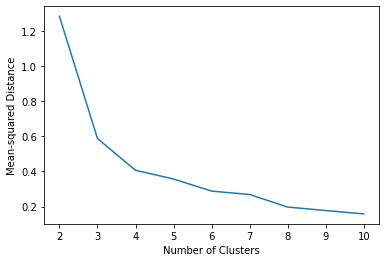

In [ ]:
X = load_data(TOY_FILE)

K_max = 10
loss = loss_per_k(X, K_max)

plt.plot(range(2,K_max+1), loss)
plt.xlabel('Number of Clusters')
plt.ylabel('Mean-squared Distance')

Run the cell below to visualize clustering for your small dataset using the K value chosen from the question above.

(100, 4)


Text(0, 0.5, 'Planet Density')

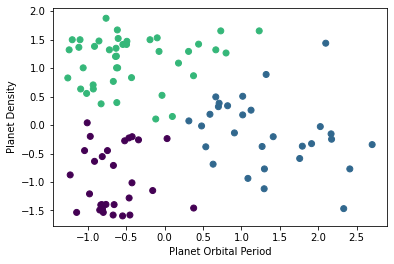

In [ ]:
K = K_ANSWER
X = load_data(TOY_FILE)
init_centers = X[0:K,:]

final_centers, final_assignment = kmeans(X, K, init_centers)

cmap = cm.get_cmap('viridis') #colormap for plotting each step
rgba = cmap(np.linspace(0,1,4))
colors = np.array([rgba[i] for i in final_assignment])
print(colors.shape)
plt.scatter(X[:,0],X[:,1], c = colors)
plt.xlabel('Planet Orbital Period')
plt.ylabel('Planet Density')

Run the cell below to visualize clustering for your full dataset using the K value chosen from the question above. Think about how you might interpret these clusterings. Why might using the first three datapoints of X somewhat bias the final clusterings? What do you think would be a better way to choose the initialization?

(2318, 4)


Text(0, 0.5, 'Planet Density')

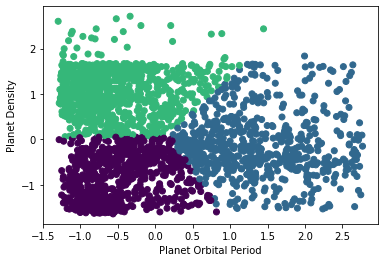

In [ ]:
K = K_ANSWER
X = load_data(FULL_FILE)
init_centers = X[0:K,:]

final_centers, final_assignment = kmeans(X, K, init_centers)

cmap = cm.get_cmap('viridis') #colormap for plotting each step
rgba = cmap(np.linspace(0,1,4))
colors = np.array([rgba[i] for i in final_assignment])
print(colors.shape)
plt.scatter(X[:,0],X[:,1], c = colors)
plt.xlabel('Planet Orbital Period')
plt.ylabel('Planet Density')

#Trying to identify a specific clustering for a scientific question
#Potential for life
#Export some images for the knowledge checks



### Choosing Poor Initial Cluster Centers 

This question now focuses on a randomly generated dataset with three identical hypothetical data clusters, each with its own distinct center. Run the two cells below to visualize an example of "bad" clustering due to poor initial cluster centers. You will then provide a NumPy array with three centers that can give the same clustering using kmeans.

In [ ]:
def bad_clusters(plot = True):
    data = pd.read_csv('./data/three_clusters.csv', header = None)
    data = np.asarray(data)
    target_clustering = pd.read_csv('./data/target_assignment.csv', header = None)
    target_clustering = np.asarray(target_clustering).flatten()
    cmap = cm.get_cmap('rainbow') #colormap for plotting each step
    rgba = cmap(np.linspace(0,1,3))
    colors = np.array([rgba[i] for i in target_clustering])
    if plot:
        plt.figure(figsize=(10,5))
        plt.scatter(data[:,0],data[:,1], facecolors = "none", edgecolors = colors)
        plt.xlim([-0.5,3.5])
        plt.ylim([0.6,1.5])
        plt.title("Target Bad Clusters")
        plt.xlabel("Feature #1")
        plt.ylabel("Feature #2")
    return data,target_clustering


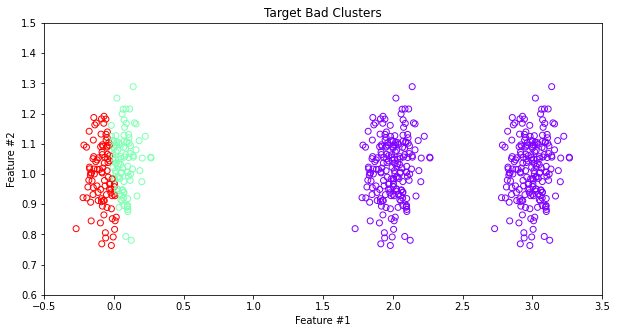

In [ ]:
X, target_clustering = bad_clusters()

In the cell below, provide your answer for a possible initialization that could give rise to the clustering above using the k-means algorithm. 



In [ ]:
bad_init_centers = np.array([[2.5,1.1],
                             [0.2,1],
                             [-0.1,1.1]])  

Run the cell below to plot the final cluster assignments based on your initialization overlaid with the target clustering. If your clustering does not match the target, a `False` answer is printed with the statement below. Use the two plots to compare your final clustering outcome to the target and change your answer for `bad_init_centers` until the statement prints `True`.

(True or False). Assignments matched intended 'bad' clustering. True


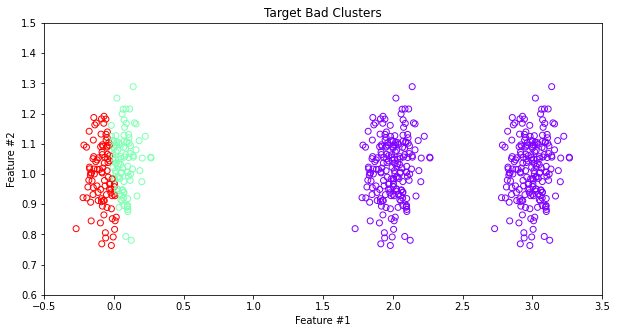

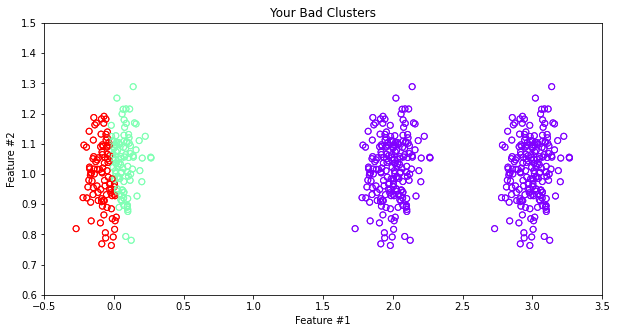

In [ ]:
X, target_clustering = bad_clusters(plot = True)
K = 3
final_centers, final_assignment = kmeans(X, K, bad_init_centers)
cmap = cm.get_cmap('rainbow') #colormap for plotting each step, use colorblind palette
rgba = cmap(np.linspace(0,1,3))
target_colors = np.array([rgba[i] for i in target_clustering])
your_colors = np.array([rgba[i] for i in final_assignment])

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.scatter(X[:,0],X[:,1], facecolors = "none", edgecolors = target_colors)
ax1.scatter(X[:,0],X[:,1], facecolors = "none", edgecolors = your_colors)
ax1.set_title('Your Bad Clusters')
ax1.set_xlim([-0.5,3.5])
ax1.set_ylim([0.6,1.5])
plt.xlabel("Feature #1")
plt.ylabel("Feature #2")

print("(True or False). Assignments matched intended 'bad' clustering. " + 
      str((final_assignment == target_clustering).all()))



### Choosing Good Initial Cluster Centers 

This question now focuses on the same randomly generated dataset with three identical hypothetical data clusters, each with its own distinct center. Run the two cells below to visualize an example of "good" clustering due to good initial cluster centers. You will then provide a NumPy array with three centers that can give the same clustering using kmeans.

In [ ]:
def good_clusters(plot = True):
    data = pd.read_csv('./data/three_clusters.csv', header = None)
    data = np.asarray(data)
    target_clustering = pd.read_csv('./data/target_good_assignment.csv', header = None)
    target_clustering = np.asarray(target_clustering).flatten()
    cmap = cm.get_cmap('rainbow') #colormap for plotting each step
    rgba = cmap(np.linspace(0,1,3))
    colors = np.array([rgba[i] for i in target_clustering])
    if plot:
        plt.figure(figsize=(10,5))
        plt.scatter(data[:,0],data[:,1], facecolors = "none", edgecolors = colors)
        plt.xlim([-0.5,3.5])
        plt.ylim([0.6,1.5])
        plt.title("Target Good Clusters")
        plt.xlabel("Feature #1")
        plt.ylabel("Feature #2")
    return data,target_clustering



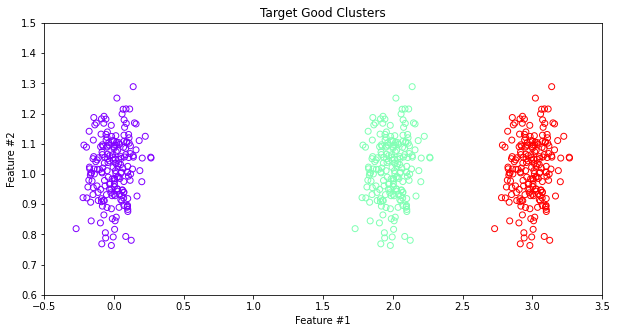

In [ ]:
X, good_clustering = good_clusters()

In the cell below, provide your answer for a possible initialization that could give rise to the clustering above using the k-means algorithm. 



In [ ]:
good_init_centers = np.array([[3,2],
                             [2,1],
                            [2.5,1.1] ])


Run the cell below to plot the final cluster assignments based on your initialization overlaid with the target clustering. If your clustering does not match the target, a `False` answer is printed with the statement below. Use the two plots to compare your final clustering outcome to the target and change your answer for `good_init_centers` until the statement prints `True`.



(True or False). Assignments matched intended 'good' clustering. True


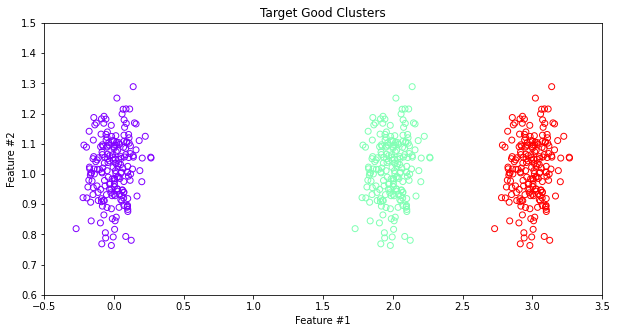

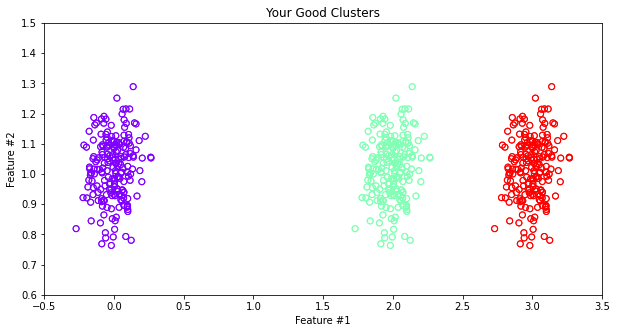

In [ ]:
X, target_clustering = good_clusters(plot = True)
K = 3
final_centers, final_assignment = kmeans(X, K, good_init_centers)
cmap = cm.get_cmap('rainbow') 
rgba = cmap(np.linspace(0,1,3))
target_colors = np.array([rgba[i] for i in target_clustering])
your_colors = np.array([rgba[i] for i in final_assignment])

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.scatter(X[:,0],X[:,1], facecolors = "none", edgecolors = target_colors)
ax1.scatter(X[:,0],X[:,1], facecolors = "none", edgecolors = your_colors)
ax1.set_title('Your Good Clusters')
ax1.set_xlim([-0.5,3.5])
ax1.set_ylim([0.6,1.5])
plt.xlabel("Feature #1")
plt.ylabel("Feature #2")

print("(True or False). Assignments matched intended 'good' clustering. " + 
      str((final_assignment == target_clustering).all()))